# 6.3 Advanced use of recurrent neural networks
In this section we will review three advanced techniques for improving the performance and generalization power of recurrent neural networks. We will demonstrate all three concepts on a temperature-forecasting problem using data points from roof sensors that measure temperature, air pressure, humidity and more. And we will then use that information to predict what the temperature will be 24 hours after the last data point.

The three techniques that will be covered are:
 - **Recurrent dropout**
 - **Stacking recurrent layers**
 - **Bidirectional recurrent layers**
 
## 6.3.1 A temperature-forecasting problem
We will work a weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Germany. This dataset measures 14 different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, and more) that were recorded every 10 minutes over a span of several years. This is a perfect dataset for working with numerical timeseries.

Let's take a look at the data:

In [37]:
import os # bring in access to terminal


# folder of data
data_dir = '/Volumes/RobStorage/Desktop/Python_Practice/DL_with_Python/data/jena_climate'
# path to dataset
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# open dataset
f = open(fname)
# read dataset
data = f.read()
# close csv file
f.close()

# formatting
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print header

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [38]:
print len(lines)

420551


In [39]:
print lines[1]

01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10


In [40]:
print len(header)

15


We have over 420K data samples to work with. Now let's convert the lines of data into a Numpy array so it can be fed into a neural network.

In [41]:
# import module
import numpy as np

# create NxN-1 Matrix of 0s [420551 rows x 15 - 1 columns]
float_data = np.zeros((len(lines), len(header) - 1))

# add an index. For row, col do this
for i, line in enumerate(lines):
    # convert dtypes to float, split at commas
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

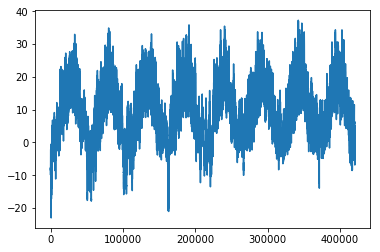

In [42]:
# plot temperature over time
import matplotlib.pyplot as plt
%matplotlib inline

temp = float_data[:, 1] # temp in deg C
plt.plot(range(len(temp)), temp)

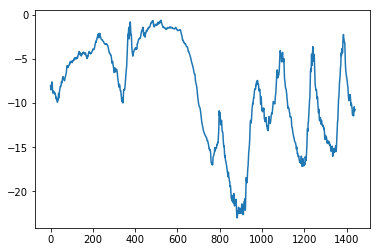

In [43]:
# View a span of 10 days
plt.plot(range(1440), temp[:1440])

There it quite a range of temperatures during this 10 day span. This must have been during a cold month! If we were to try and predict the average temperature of the next month given a few months of past data, the problem would be easy, due to the reliable year-scale seasonality of the data. But viewing the data over a scale of days, the temperature is a lot more sporadic. Is this timeseries predictable at a daily scale?

## 6.3.2 Preparing the data
Given data going as far back as `lookback` timesteps (10 minutes per timestep) and sampled every `steps` timesteps, can you predict the temperature in `delay` timesteps?
 - `lookback = 720` - Observations will go back 5 days.
 - `steps = 6` - Observations will be samples at one per hour.
 - `delay = 144` - Targets will be 24 hours in the future.
 
To get started, we need to do two things:
 1. Preprocess the data to a format a neural network can ingest. The data is already numerical, so this task is a bit easier than vectorization. But each feature in the data is on a different scale, so we need to normalize each feature independently so that they all take small values of a similar scale.
 2. Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future.
 
We will preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. Our training data will be the first 200,000 timesteps, so we will compute the mean and standard deviation on this fraction of the data.
 
**NORMALIZING THE DATA**

In [44]:
print len(float_data)

420551


In [45]:
# first 200,000 timesteps
# mean of each column
mean = float_data[:200000].mean(axis=0)
mean

array([ 988.88635885,    9.07734895,  283.14631345,    4.44854725,
         75.35405895,   13.3829553 ,    9.29695535,    4.08591725,
          5.8752111 ,    9.40521005, 1217.51429655,    2.1510037 ,
          3.56950915,  176.21703355])

In [46]:
# What does float data look like?
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

In [47]:
# subtract the mean from float_data
float_data -= mean

In [48]:
float_data[0]

array([  7.63364115, -17.09734895, -17.74631345, -13.34854725,
        17.94594105, -10.0529553 ,  -6.18695535,  -3.86591725,
        -3.9352111 ,  -6.28521005,  90.23570345,  -1.1210037 ,
        -1.81950915, -23.91703355])

In [49]:
# find standard deviation
std = float_data[:200000].std(axis=0)
std

array([ 8.48043388,  8.85249908,  8.95324185,  7.16584991, 16.72731652,
        7.68914559,  4.19808168,  4.84034436,  2.66564926,  4.25206364,
       42.48884277,  1.53666449,  2.33067298, 86.61322998])

In [50]:
# divide the float_data by each columns standard deviation
float_data /= std

In [51]:
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

We started with a dataset that consisted of a bunch of numerical weather measurements, all on different scales. And now we have a normal distribution of each feature, maintaining the relationship between timesteps.

Now we will build our Generator. The generator will *yield* a tuple of the shape `[samples, targets]`, where `samples` is a batch of input data and `targets` is the corresponding array of target temperatures. The Generator takes in the following 8 arguments as inputs.

- **`data`** - The original array of floating-point data, which we normalized
- **`lookback`** - How many timesteps back the input data should go.
- **`delay`** - How many timesteps in the future the target should be.
- **`min_index`** and **`max_index`** - Indicies in the data array that indicate which timesteps to draw from. Useful for keeping a segment of the data for validation and another for testing.
- **`shuffle`** - Whether to shuffle the samples or draw them in chronological order.
- **`batch_size`** - The number of samples per batch.
- **`step`** - The period, in timesteps, at which we sample data. We'll set it to 6 so we draw every hour.

In [52]:
# Generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Now we will use the abstract `generator` function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: training looks at the first 200,000 timesteps, validation looks at the next 100,000, and testing looks at the rest.

**PREPARING TRAINING, VALIDATION, TEST GENERATORS**

In [53]:
# lookback is how many timesteps back the input data should go
lookback = 1440 # if hours, then 60 days. if 10 min, then 10 days
step = 6 # 6 x 10min timesteps = 60 min timestep
delay = 144 # How many timesteps in the future the target should be. When are we trying to predict?
#batch_size = 128 # Number of samples per batch
batch_size = 32

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [54]:
# how many steps to draw from val_gen in order to see the entire val set
val_steps = (300000 - 200001 - lookback)

# how many steps to draw from test_gen in order to see entire test set
test_steps = (len(float_data) - 300001 - lookback)

## 6.3.3 A common-sense, non-machine-learning baseline

Before we start using the black-box deep learning models to solve the temperature prediction problem, let's try a simple, common-sense approach. This will serve as a sanity check, and will establish a baseline that we will have to beat in order to demonstrate the usefulness of more-advanced machine learning models.

Our common-sense approach will be always guessing that the temperature in 24 hours will be the same as the temperature right now. Let's evaluate this approach using the mean absolute error metric:

`np.mean(np.abs(preds - targets))`

**COMPUTING THE COMMON-SENSE BASELINE MAE**

In [55]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print np.mean(batch_maes)
    
evaluate_naive_method()

0.2895898077635053


This yields an MAE of 0.29. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn't immediately interpretable. It translates to an average absolute error of 0.29 x `temperature_std` degrees Celsius: 2.57 deg. C, or equivalent to about 4.6 degrees f.

**CONVERTING MAE BACK TO CELSIUS ERROR**

In [56]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

This is a fairly large average absolute error. Now the game is to use our knowledge of deep learning to do better.

## A basic machine-learning approach

Just like it is useful to establish a common-sense baseline before trying machine learning approaches, it's also useful to try simple, cheap machine-learning models before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity we throw at the problem is legitimate and delivers real benefits.

The next section shows a fully connected model that starts by flattening the data and then runs it through two `Dense` layers. Note the lack of an activation function of the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Because we evaluate on the exact same data and with the exact same metric we did with the common sense approach, the results will be directly comparable.

**TRAINING AND EVALUATING A DENSELY CONNECTED MODEL**

In [57]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [58]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 282s - loss: 1.1743 - val_loss: 0.8549
Epoch 2/20
500/500 [==============================] - 275s - loss: 0.4527 - val_loss: 0.3434
Epoch 3/20
500/500 [==============================] - 324s - loss: 0.3242 - val_loss: 0.3036
Epoch 4/20
500/500 [==============================] - 291s - loss: 0.2966 - val_loss: 0.3359
Epoch 5/20
500/500 [==============================] - 279s - loss: 0.2915 - val_loss: 0.3000
Epoch 6/20
500/500 [==============================] - 280s - loss: 0.2787 - val_loss: 0.3468
Epoch 7/20
500/500 [==============================] - 287s - loss: 0.2767 - val_loss: 0.3111
Epoch 8/20
500/500 [==============================] - 282s - loss: 0.2742 - val_loss: 0.3095
Epoch 9/20
500/500 [==============================] - 276s - loss: 0.2615 - val_loss: 0.3339
Epoch 10/20
500/500 [==============================] - 277s - loss: 0.2571 - val_loss: 0.3082
Epoch 11/20
500/500 [==============================] - 278s - loss: 0

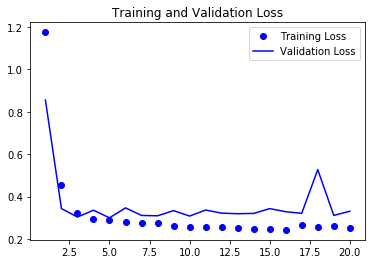

In [59]:
# Draw loss curves for validation and training
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. If a simple, well-performing baseline model exists to go from the data to the targets, why didn't this model we're training find it and improve on it? This is because the simple solution isn't what our training setup is looking for. The spae of models in which we're searching for a solution is the space of all possible two-layer networks with the configuration we defined. These networks are already fairl complicated. When we're looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it's part of the hypothesis space. 

## 6.3.5 A first recurrent baseline

The first fully connected approach didn't do well, but that doesn't mean machine learning isn't applicable to this problem. The previous apprach first flattened the timeseries, which removed the notion of time from the input data. Let's instead look at the data as what it is: a sequence, where causality and order matter. We'll try a recurrent-sequence processing model. It should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.

Instead of the `LSTM` layer introduced in the previous section, we'll use the `GRU` layers work using the same principle as LSTM, but they're somewhat streamlined and thus cheaper to run. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

**TRAINING AND EVALUATING A GRU-BASED MODEL**

In [60]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

![GRU](images/6_3_5_GRU.jpg)

Much better! We can significantly beat the common-sense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

The new validation MAE of ~0.265 translates to a mean absolute error of 2.35 deg. C (or 4.23 deg F) after denormalization. That's a solid gain on the initial error of 2.57 deg. C, but we probably still have a bit of a margin for improvement.

## 6.3.6 Using recurrent dropout to fight overfitting

It's clear from the training and validation curves that the model is overfitting. A classic technique for fighting overfitting is dropout, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. The same dropout mask should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep.

Also, in order to regularize the representations formed by the recurrent gates of layers, a temporally constant dropout mask should be applies to the inner recurrent activations of the layer. Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Let's add dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we'll train the network for twice as many epochs.

**TRAINING AND EVALUATING A DROPOUT-REGULARIZED GRU-BASED MODEL**

In [61]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

![RNN Dropout](images/6_3_6_RNNdropout.jpg)

Success! We're no longer overfitting during the first 30 epochs. Although we have more stable evaluation scores, our best scores aren't much lower than they were previously.

## 6.3.7 Stacking recurrent layers

Because we are not longer overfitting, but are having a performance bottleneck, we should consider increasing the capacity of the network. It's generally a good idea to increase the capacity of our network until overfitting becomes the primary obstacle. As long as we aren't overfitting too badly, we're likely under capacity.

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, the Google Translate algorithm is powered by a stack of seven large `LSTM` layers. To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (3D tensor) rather than their output at the last timestep. This is done by specifying `return_sequences=True`.

**TRAINING AND EVALUATING A DROPOUT-REGULARIZED, STACKED GRU MODEL**

In [62]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

![Stacked GRU](images/6_3_7_stackedGRU.jpg)
We can see that the added layer does improve the results a bit, though not significantly. We can draw two conclusions:
 - Because we're still not overfitting too badly, we could safely increase the size our layers in a quest for validation-loss improvement. This has a non-negligible computation cost, though.
 - Adding a layer didn't help by a significant factor, so we may be seeing a diminishing return from increasing network capacity at this point.
 
## 6.3.8 Using bidirectional RNNs

The last technique introduced in this section is called **bidirectional RNNs**, which is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It's frequently used in natural-language processing.

RNNs are notably order dependent, or time dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely the reason they perform well on problems where order is meaningful, such as the temperature-forecasting problem. A bidirectional RNN exploits the order sensitivity of RNNs: consisting of using two regular RNNs, such as `GRU` and `LSTM` layers, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Could the RNNs have performed well enough if they processed input sequences in reverse-chronological order (newer timesteps first)? Let's give this a try to see what happens.

![reverse](images/6_3_8_reverse.jpg)

The reversed-order GRU strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of our approach. The underlying GRU layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem. Thus the chronological version of the layer is bound to outperform the reversed-order version. Importantly, this isn't true for many other problems, including natural language: intuitively, the importance of a word in undertanding a sentence isn't usually dependent on its position in the sentence. Let's try the same trick on the LSTM IMDB example from section 6.2

**TRAINING AND EVALUATING AN LSTM USING REVERSED SEQUENCES**

In [63]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

We get performance nearly identical to that of the chronological-order LSTM. Remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming the hypothesis that, although word order does matter in understanding language, which order we use isn't crucial. Importantly, an RNN trained on reversed sequences will learn different representations than one trained on the original sequences.

A bidirectional RNN exploits this idea to improve on the performance of chronological-order RNNs. It looks at its pure sequence both ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional](images/6_3_8_bidirectional.jpg)

**TRAINING AND EVALUATING A BIDIRECTIONAL LSTM**

In [64]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

It performs slightly better than the regular LSTM we tried in the previous section, achieving over 89% validation accuracy. It also seems to overfit more quickly, which is unsurprising because a bidirectional layer has twice as many parameters as a chronological LSTM. With some regularization, the bidirectional approach would likely be a strong performer on this task.

Now let’s try the same approach on the temperature-prediction task.

In [65]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

This performs about as well as the regular GRU layer. It’s easy to understand why: all the predictive capacity must come from the chronological half of the network, because the reverse-chronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case).

## 6.3.9 Going even further
There are many other things we could try, in order to improve performance on the temperature-forecasting problem:

 - Adjust the number of units in each recurrent layer in the stacked setup. The current choices are largely arbitrary and thus probably suboptimal.
 - Adjust the learning rate used by the RMSprop optimizer.
 - Try using LSTM layers instead of GRU layers.
 - Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even a stack of Dense layers.
 - Don’t forget to eventually run the best-performing models (in terms of validation MAE) on the test set! Otherwise, we’ll develop architectures that are overfitting to the validation set.
 - As always, deep learning is more an art than a science. We can provide guidelines that suggest what is likely to work or not work on a given problem, but, ultimately, every problem is unique; we’ll have to evaluate different strategies empirically. There is currently no theory that will tell us in advance precisely what we should do to optimally solve a problem. We must iterate.

## 6.3.10. Wrapping up
Here is the take away from this section:

 - When approaching a new problem, it’s good to first establish common-sense baselines for our metric of choice. If we don’t have a baseline to beat, we can’t tell whether we’re making real progress.
 - Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be our best option.
 - When we have data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.
 - To use dropout with recurrent networks, we should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all we have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
 - Stacked RNNs provide more representational power than a single RNN layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.
 - Bidirectional RNNs, which look at a sequence both ways, are useful on natural-language processing problems. But they aren’t strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

**NOTE**

There are two important concepts we won’t cover in detail here: recurrent attention and sequence masking. Both tend to be especially relevant for natural-language processing, and they aren’t particularly applicable to the temperature-forecasting problem. We’ll leave them for future study outside of this book.